### imports and functions

This code formalizes [this sketch](https://community.plot.ly/t/use-plotly-offline-to-save-chart-as-image-file/408/25) laid out on the `plotly` community forum by user `broken_symlink`. It uses `selenium` to click the download button. This is an attempt to programmatically save out plot files via `plotly.offline` (do not require authentication with `plotly` servers, and do not open a web page).

Requests for this are very common:

- requests/mentions via `plotly` github: [351](https://github.com/plotly/plotly.py/issues/351), [352](https://github.com/plotly/plotly.py/issues/352), [483](https://github.com/plotly/plotly.py/issues/483), [564](https://github.com/plotly/plotly.py/issues/564), [596](https://github.com/plotly/plotly.py/issues/596), [856](https://github.com/plotly/plotly.py/issues/856), [880](https://github.com/plotly/plotly.py/issues/880)
- this [question](https://community.plot.ly/t/use-plotly-offline-to-save-chart-as-image-file/408) at the `plotly` community forums
- [this](https://stackoverflow.com/questions/40243446/how-to-save-plotly-offline-graph-in-format-png) and [this](https://stackoverflow.com/questions/34957790/use-plotly-offline-to-generate-graphs-as-images) on StackOverflow

I couldn't get this to work with `phantomjs`, which was my aim since the original code uses the `firefox` webdriver and actually opens a browser instance. After much googling, it turns out downloading isn't super straihtforward in `phantomjs`.

- [this SO post](https://stackoverflow.com/a/25756960/495990) suggests `phantomjs` doesn't really support downloads
- another [SO answer](https://stackoverflow.com/a/27911585/495990) that combines `phantomjs` with `urllib` to download
- [an issue](https://github.com/ariya/phantomjs/issues/10052) going back to 2011 about downloads!
- [a PR](https://github.com/ariya/phantomjs/pull/14225) that *looks* like downloads was recently merged into `phantomjs`, but I admit I don't know how to use it
- this [SO answer](https://stackoverflow.com/a/38655474/495990) features using `chromedriver` which is how I ultimiately did this

In tinkering with the `chromedriver` approach, it appears we can do two things:

- specify `image='type', image_filename='name'` to `plotly.offline.plot()`, which will auto-download the plot upon opening. When using the `selenium` webdriver, we don't have to do anything but load the file.
- alternatively, the [original sketch](https://community.plot.ly/t/use-plotly-offline-to-save-chart-as-image-file/408/25) used the following (after loading the page):

```
export_button = driver.find_element_by_xpath("//a[@data-title='Download plot as a png']")
export_button.click()
```

I didn't use this for two reasons. The first is without needing it... why use it? The second is that I actually ended up getting *two* downloads for each iteration! I discovered that the two relevant options *might* not be mutually exclusive (see [this inquiry](https://community.plot.ly/t/is-image-foo-required-for-image-filename-bar-with-plotly-offline-plot/7476)). Basically, if you pass `image='png'`, the file auto-downloads upon opening... but running the `export_button.click()` *also* downloads it, so you get two files. In addition, removing `image='png'` but leaving `image_filename='name'` seems to ignore the filename so you get `newplot.png` upon the simulated click event.

At present, it seems best to rely on the auto-download feature as it's simpler and we can specify a filename.

Lastly, I had never used `pyvirtualdisplay` before. I didn't think it was necessary, as I was able to run the code just fine and get a file. Out of curiosity, I made a separate `.py` file and ran it *outside* of Jupyter lab and a `chromium` instance popped open and then closed. In addition, I accidentally discovered that you need the `Display()` instance created before the `webdriver`. Speaking from a total noob perspective, in my mind I imagine the browser redirecting to the fake display but only if it exists.

In [1]:
import os
import pandas as pd
import plotly
import plotly.graph_objs as go
import time

from selenium import webdriver
from PIL import Image
from pyvirtualdisplay import Display

      
### from bokeh/io, slightly modified to avoid their import_required util
### didn't ultimately use, but leaving in case I figure out how to stick wtih phentomjs
### - https://github.com/bokeh/bokeh/blob/master/bokeh/io/export.py
def create_default_webdriver():
    '''Return phantomjs enabled webdriver'''
    phantomjs_path = detect_phantomjs()
    return webdriver.PhantomJS(executable_path=phantomjs_path, service_log_path=devnull)


### based on last SO answer above
### - https://stackoverflow.com/questions/38615811/how-to-download-a-file-with-python-selenium-and-phantomjs
def create_chromedriver_webdriver(dload_path):
    display = Display(visible=0)
    display.start()
    chrome_options = webdriver.ChromeOptions()
    prefs = {"download.default_directory": dload_path}
    chrome_options.add_experimental_option("prefs", prefs)
    driver = webdriver.Chrome(chrome_options=chrome_options)
    return driver, display

### create a plot

Here we create some data and save the plot as an html file for reading in

In [ ]:
df = pd.DataFrame(
    {'fruits': ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries'],
     'counts': [5, 3, 4, 2, 4, 6] })

data = [go.Bar(x=df['fruits'],
               y=df['counts'])]

dload = os.path.expanduser('~/Downloads')
html_file = 'plotly-fruit-plot.html'
fname = 'plotly-fruit-plot'

### original code contained height/width for the display and chromium webdriver
### I found they didn't matter; specifying the image size to generate will 
### produce a plot of that size no matter the webdriver
plotly.offline.plot(data, filename=html_file, auto_open=False,
                    image_width=1280, image_height=800,
                    image_filename=fname, image='png')

### the magic



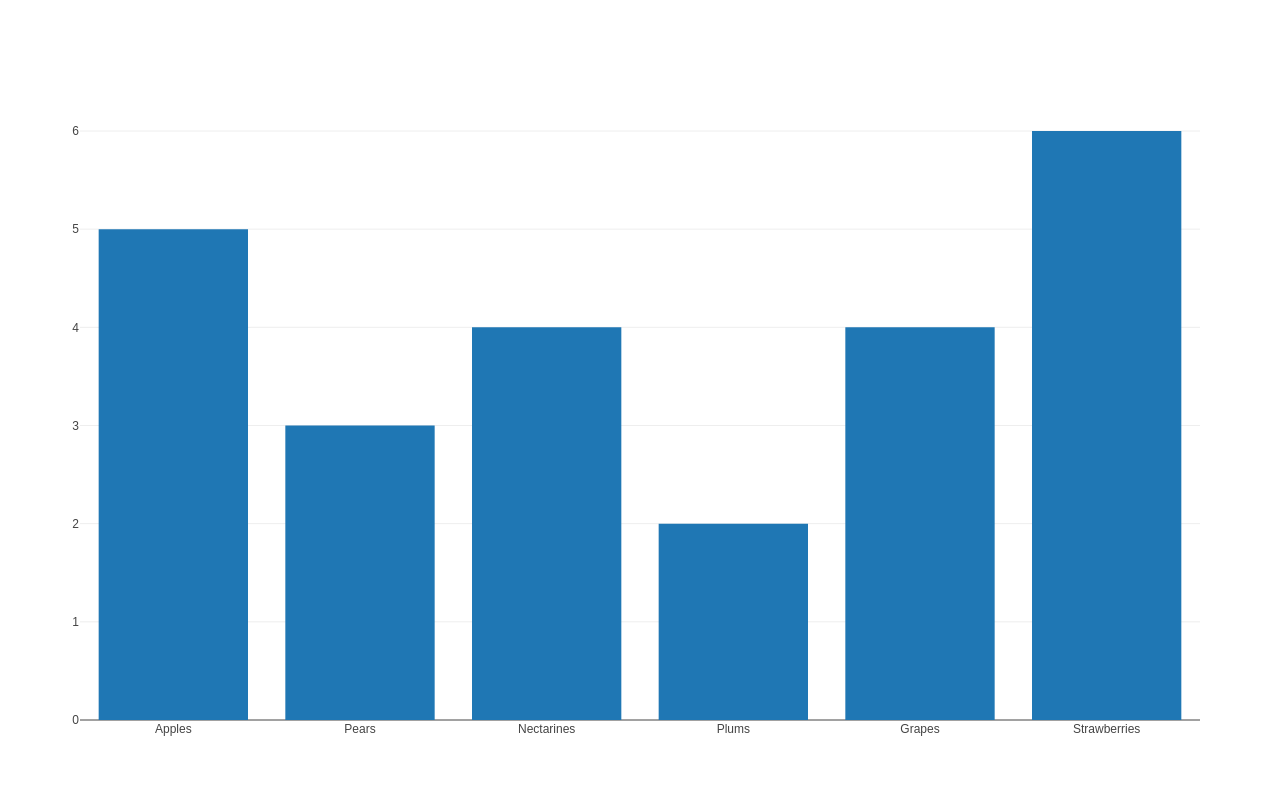

In [3]:
### create webdrive, open file, maximize, and sleep
driver, display = create_chromedriver_webdriver(dload)

driver.get('file:///{}'.format(os.path.abspath(html_file)))

# make sure we give the file time to download
time.sleep(1)

### was in the SO post and could be a more robust way to wait vs. just sleeping 1sec
# while not(glob.glob(os.path.join(dl_location, filename))):
#     time.sleep(1)

driver.close()
display.stop()

image = Image.open('{}.png'.format(os.path.join(dload, fname)))
image